In [58]:
import torch
import numpy as np
! pip install shapely

Defaulting to user installation because normal site-packages is not writeable


In [60]:
ck  = torch.load('model_49.ckpt')

In [61]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from model import  DETR
from cornell_dataset import CornellDataset
from hungarian import HungarianMatcher
from view_bbox import draw_bbox
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
dataset_path = "dataset/cornell"
img_set = "train"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
train_dataset = CornellDataset(dataset_path, "train", normalize)
val_dataset = CornellDataset(dataset_path, "val", normalize)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
model = DETR(num_class=21).to(device)
model.load_state_dict(ck['model'])

<All keys matched successfully>

In [64]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

In [65]:
for i, (x_val, y_val) in enumerate(val_loader):
    x_val = x_val.to(device)
    ort,box = y_val

    bound, classification = model(x_val)
    cla = torch.argmax(classification,dim=-1)
    idx = torch.where(cla!=20)
    print(idx)
    id_x = idx[0].cpu().detach().numpy()
    id_y = idx[1].cpu().detach().numpy()
    with torch.no_grad():
        b= box_cxcywh_to_xyxy(bound*224)
        box = box_cxcywh_to_xyxy(box*224)
    break

(tensor([13, 16, 23, 24, 24, 26, 31], device='cuda:0'), tensor([4, 4, 4, 0, 4, 4, 4], device='cuda:0'))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


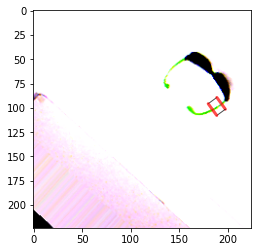

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict


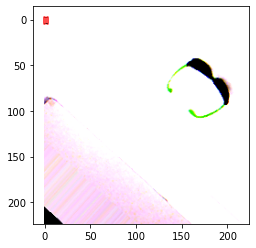

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


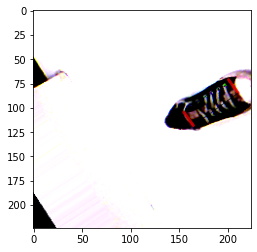

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict


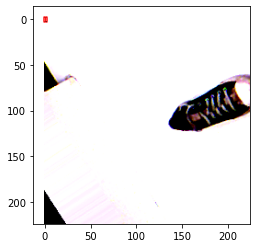

Target


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


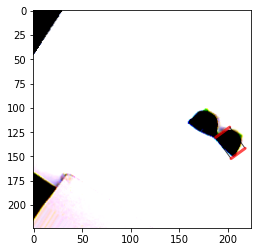

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict


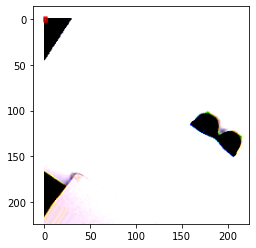

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


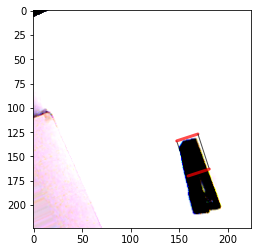

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict


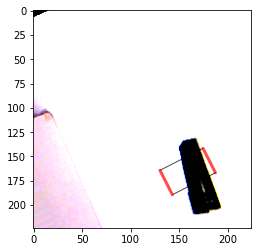

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


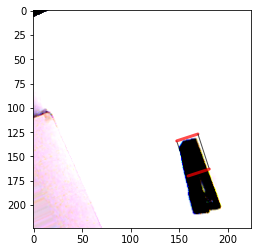

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict


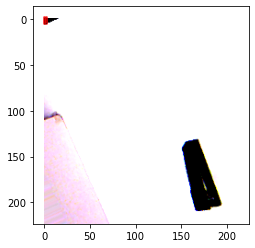

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


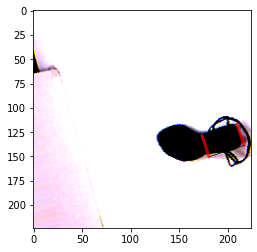

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict


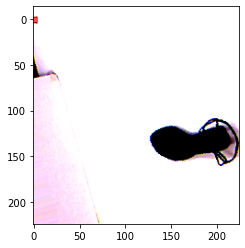

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target


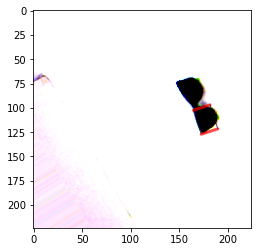

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict


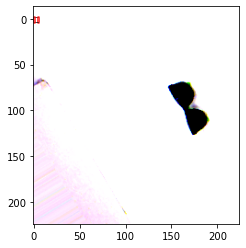

In [66]:
with torch.no_grad():
    for k,l in zip(id_x,id_y):
        print('Target')
        d = draw_bbox(box[k],ort[k])
        d.draw_rotated_box(x_val[k].cpu().detach().permute(1,2,0).numpy(),True)
#         print('predict with zero orientation')
#         d = draw_bbox(b[k,l,:].cpu().detach().numpy(),0)
#         d.draw_rotated_box(x_val[k].cpu().detach().permute(1,2,0).numpy(),True)
        print('predict')
        d = draw_bbox(b[k,l,:].cpu().detach().numpy(),cla[k,l].cpu().detach().numpy())
        d.draw_rotated_box(x_val[k].cpu().detach().permute(1,2,0).numpy(),True)
        
        #break
        

In [67]:
for i in range(32):
    q = torch.where(cla[i]!=20)
    print(cla[[i]*q[0].size(0),q[0]].cpu().detach().numpy(),ort[i].cpu().detach().numpy())

[] 5
[] 5
[] 8
[] 8
[] 3
[] 0
[] 10
[] 10
[] 9
[] 10
[] 2
[] 5
[] 12
[0] 4
[] 6
[] 6
[0] 4
[] 18
[] 10
[] 1
[] 9
[] 16
[] 10
[0] 14
[3 0] 12
[] 16
[0] 2
[] 5
[] 7
[] 19
[] 18
[0] 12


In [68]:
ort

tensor([ 5,  5,  8,  8,  3,  0, 10, 10,  9, 10,  2,  5, 12,  4,  6,  6,  4, 18,
        10,  1,  9, 16, 10, 14, 12, 16,  2,  5,  7, 19, 18, 12],
       dtype=torch.int32)

In [69]:
cla

tensor([[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20,  0, 20, 20, 2

Defaulting to user installation because normal site-packages is not writeable
